In [159]:
import torch
import torchvision
import torchvision.transforms as transforms

In [160]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='results/CIFAR-10', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


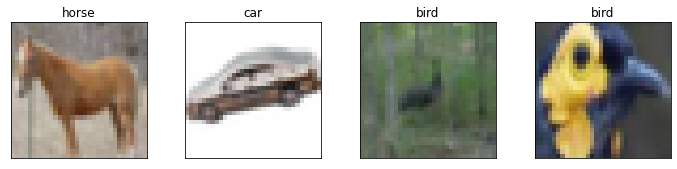

In [161]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [182]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #Conv Layer block 3 
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5),
            nn.ReLU(),

        )


        self.fc_layer = nn.Sequential(
            nn.Linear(26, 10)
        )
        

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(-1, 26)
        
        # fc layer
        x = self.fc_layer(x)

        return x
    
net = Net()

In [183]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [184]:
import os

model_directory_path = 'results/CIFAR-10/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')

[1,  2000] loss: 2.080
[1,  4000] loss: 1.738
[1,  6000] loss: 1.593
[1,  8000] loss: 1.529
[1, 10000] loss: 1.496
[1, 12000] loss: 1.441
[2,  2000] loss: 1.359
[2,  4000] loss: 1.372
[2,  6000] loss: 1.352
[2,  8000] loss: 1.326
[2, 10000] loss: 1.300
[2, 12000] loss: 1.304
Finished Training.
Saved model parameters to disk.


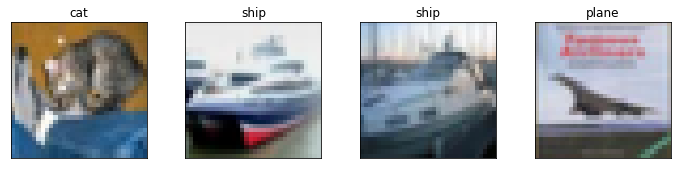

In [185]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [186]:
outputs = net(images)

In [187]:
outputs


tensor([[ 9.6028e-02, -1.8943e+00,  1.1717e+00,  3.5353e+00,  1.6708e-01,
          2.4038e+00,  5.9828e-01, -2.7415e-01, -3.0885e-01, -2.1999e+00],
        [ 4.9508e+00,  6.5434e+00, -1.9677e+00, -3.7767e+00, -3.8342e+00,
         -4.4994e+00, -6.8322e+00, -6.5693e+00,  8.6814e+00,  4.5993e+00],
        [ 1.9184e+00,  2.0132e+00,  2.1144e-01, -1.3333e+00, -5.7688e-01,
         -1.6519e+00, -3.0510e+00, -2.0416e+00,  3.6314e+00,  6.4878e-03],
        [ 3.6212e+00,  1.2034e+00,  6.1051e-01, -1.9971e+00,  6.7976e-01,
         -2.8388e+00, -3.1061e+00, -1.4433e+00,  3.4933e+00,  3.9871e-02]],
       grad_fn=<AddmmBackward>)

In [188]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[2.0215e-02, 2.7622e-03, 5.9268e-02, 6.2996e-01, 2.1703e-02, 2.0321e-01,
         3.3403e-02, 1.3960e-02, 1.3484e-02, 2.0350e-03],
        [2.0694e-02, 1.0174e-01, 2.0473e-05, 3.3536e-06, 3.1661e-06, 1.6281e-06,
         1.5796e-07, 2.0546e-07, 8.6298e-01, 1.4560e-02],
        [1.2271e-01, 1.3491e-01, 2.2261e-02, 4.7498e-03, 1.0120e-02, 3.4537e-03,
         8.5248e-04, 2.3391e-03, 6.8047e-01, 1.8136e-02],
        [4.7356e-01, 4.2206e-02, 2.3327e-02, 1.7194e-03, 2.5000e-02, 7.4105e-04,
         5.6723e-04, 2.9917e-03, 4.1670e-01, 1.3184e-02]],
       grad_fn=<SoftmaxBackward>)


In [189]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.6300
ship - 0.8630
ship - 0.6805
plane - 0.4736


In [190]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 53.76%


In [191]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 55.8
car        - 70.2
bird       - 29.4
cat        - 53.1
deer       - 46.1
dog        - 35.2
frog       - 64.3
horse      - 63.5
ship       - 71.8
truck      - 48.2


<AxesSubplot:>

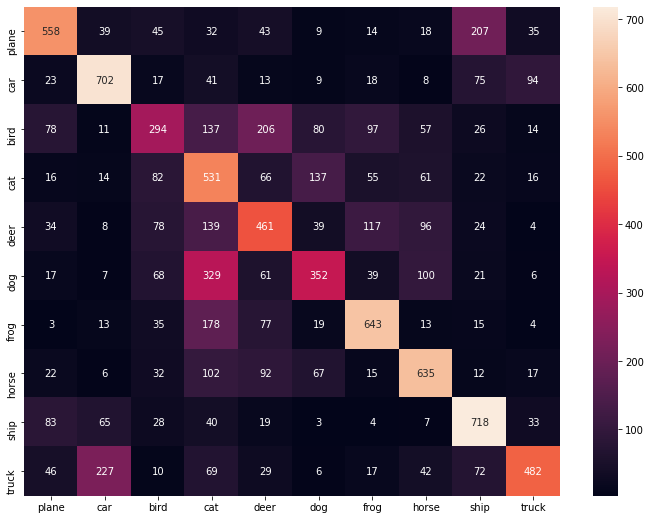

In [192]:
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(confusion_matrix, xticklabels = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'], yticklabels = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'], annot=True, fmt='d')
